# Importo i dati

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn import metrics
from sklearn.datasets import make_blobs
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import statistics
from scipy.spatial.distance import pdist, squareform
import pygeohash as pgh
import geohash as gh
import geopandas as gpd
from polygon_geohasher.polygon_geohasher import geohash_to_polygon 

import folium
from folium import plugins

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

In [2]:
year = '2016' #change if needed
csv_folder = '../csv/'+year
df = pd.read_csv(csv_folder+'/df.csv')
df.drop(['Unnamed: 0'], axis='columns', inplace=True)
df

Screen_name     UserID             TweetID  \
0      madikeeper12  868809325  779072240994234368   
1      madikeeper12  868809325  781615843406819329   
2      madikeeper12  868809325  781870800156499968   
3      madikeeper12  868809325  780003801260404736   
4      madikeeper12  868809325  779443101123260417   
..              ...        ...                 ...   
656  antoniocassisa  358042635  781879291911016448   
657      SefaMermer  293157588  780753755830677504   
658      SefaMermer  293157588  780756143668953088   
659     matteluca89  494389053  779638196258811904   
660      anabrmotta   98254561  781123690343698432   

                         Coords        Lat        Lon  \
0    [43.72666207, 10.41268069]  43.726662  10.412681   
1    [43.72666207, 10.41268069]  43.726662  10.412681   
2    [43.72666207, 10.41268069]  43.726662  10.412681   
3            [43.7167, 10.3833]  43.716700  10.383300   
4          [43.70561, 10.42059]  43.705610  10.420590   
..                          ...        ...        ...   
656          [43.7167, 10.3833]  43.716700  10.383300   
657          [43.7167, 10.3833]  43.716700  10.383300   
658          [43.7167, 10.3833]  43.716700  10.383300   
659  [43.71544235, 10.40051616]  43.715442  10.400516   
660         [43.72263, 10.3948]  43.722630  10.394800   

                         Created_At  \
0    Thu Sep 22 21:37:51 +0000 2016   
1    Thu Sep 29 22:05:13 +0000 2016   
2    Fri Sep 30 14:58:19 +0000 2016   
3    Sun Sep 25 11:19:32 +0000 2016   
4    Fri Sep 23 22:11:31 +0000 2016   
..                              ...   
656  Fri Sep 30 15:32:04 +0000 2016   
657  Tue Sep 27 12:59:35 +0000 2016   
658  Tue Sep 27 13:09:05 +0000 2016   
659  Sat Sep 24 11:06:45 +0000 2016   
660  Wed Sep 28 13:29:35 +0000 2016   

                                                  Text  
0    Cieli infuocati.\n\n#picoftheday #quotesofthed...  
1    Prospettive.. \nunite a casa #ilselfone\n#team...  
2    Non occorre essere matti per lavorare qui, ma ...  
3    RunOnSunDay 🏃🏽‍♀️☀️\n#run #running #runner #ni...  
4    La vita è come la fotografia sono necessari i ...  
..                                                 ...  
656  I mì ómini \n#son #figli #boys @ Pisa, Italy h...  
657  #love #tbt #tagforlikes #TFLers #tweegram #pho...  
658  #love #tbt #tagforlikes #TFLers #tweegram #pho...  
659  Last saturday I went out with my #chinese teac...  
660  Já que é pra tombar, ela tombou (só um pouquin...  

[661 rows x 8 columns]

#### Creo un dataframe contenente soltanto le coordinate (lat e long unite):

In [3]:
df_coords = df['Coords']
df_coords

0      [43.72666207, 10.41268069]
1      [43.72666207, 10.41268069]
2      [43.72666207, 10.41268069]
3              [43.7167, 10.3833]
4            [43.70561, 10.42059]
                  ...            
656            [43.7167, 10.3833]
657            [43.7167, 10.3833]
658            [43.7167, 10.3833]
659    [43.71544235, 10.40051616]
660           [43.72263, 10.3948]
Name: Coords, Length: 661, dtype: object

# Normalzzo i dati

In order to start the clustering analysis it is necessary to standardize data. Since it is very necessary for the data to have the same scale in order to avoid bias in the outcome, data standardization is used in machine learning to make model training less sensitive to the scale of features, which in our case allows the algorithm to converge to better weights and leads to a more accurate analysis.

The fist step is to create a smaller dataset from the original one, that will contain only the features that we need to analyze, latitude and longitude. Afterwards, it is possible to proceed with the standardization of the new dataset.

In [4]:
X = df[['Lat', 'Lon']]
X_norm = StandardScaler().fit_transform(X)
X_norm

array([[ 1.23016184,  2.47963274],
       [ 1.23016184,  2.47963274],
       [ 1.23016184,  2.47963274],
       ...,
       [-0.44122649, -1.48067222],
       [-0.65222897,  0.83994189],
       [ 0.55368047,  0.06944478]])

# DBSCAN

Since there is relatively a small amout of data left after the preparation and filtering phase for conducting an analysis that requires a certain level of detail, choosing a good algorithm to carry out a clustering operation demands several tests, changing and adapting from time to time the parameters to obtain accurate results.
Firstly, we try to use DBSCAN (for details see section n. tot), which is an algorithm capable of defining clusters following the idea that a point belongs to a cluster if it is close to many points of that cluster. 

## Knee method with Nearest Neighbors

With the aim of finding a set of parameters as accurate as possible, we rely on a known criteria.

One method used to estimate the optimal epsilon value is to use nearest neighbor distances. If you recall, nearest neighbors is a supervised ML clustering algorithm which clusters new data points based on their distance from other “known” data points. We train a KNN model on labeled training data to determine which data points belong to which cluster. Then when we apply the model to new data, the algorithm determines which cluster the new data point belongs to based on the distance to trained clusters. We do have to determine the “k” parameter a-priori which specifies how many closest or nearest neighboring points the model will consider before assigning the new data point to a cluster.

To determine the best epsilon value, we calculate the average distance between each point and its closest/nearest neighbors. We then plot a k-distance and choose the epsilon value at the “elbow” of the graph. On the y-axis, we plot the average distances and the x-axis all the data points in your dataset.

from https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31

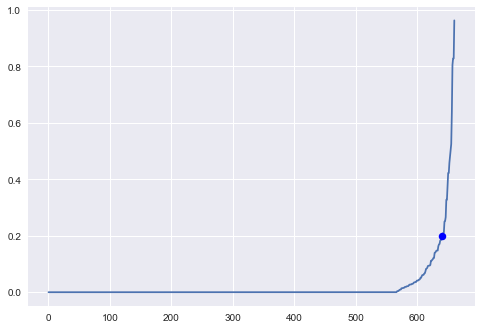

In [5]:
plt.style.use('seaborn')
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_norm)
# .kneighbors finds the K-neighbors of a point and returns indices of and distances to the neighbors of each point.
distances, indices = nbrs.kneighbors(X_norm) 
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)
plt.plot(640,0.2,'b.', markersize=15)

From the plot in fig. {ref}, it seems that the best epsilon value may be around 0.2.

## Prove Clustering

According to the plot from the previous analysis, the parameters set for the first analysis are epsilon equal to 0.2 and min_samples equal to 5. 

In [6]:
# prova 1: density based clustering
print('#DBSCAN 1')

parameters_ds1 = 'eps=0.2, min_samples=5'
dbscan1 = DBSCAN(eps=0.2, min_samples=5)
dbscan1.fit(X_norm)
labels_dbscan1 = dbscan1.labels_

hist_ds1, bins_ds1 = np.histogram(labels_dbscan1, bins=range(-1, len(set(labels_dbscan1)) + 1))

n_clust_ds1 = len(bins_ds1)
big_clust_ds1 = max(hist_ds1)
s_ds1 = metrics.silhouette_score(X_norm, labels_dbscan1)
mean_ds1 = statistics.mean(hist_ds1)
median_ds1 = statistics.median(hist_ds1)
out_ds1 = dict(zip(bins_ds1, hist_ds1))[-1]*100/sum(hist_ds1)

print ('parameters:', parameters_ds1)
print ('n. clusters:', n_clust_ds1)
print ('biggest cluster dimension:', big_clust_ds1)
print ('silhouette:', s_ds1)
print ('mean cluster dimension:', mean_ds1)
print ('median cluster dimension:', median_ds1)
print ('% outliers:', out_ds1)

#DBSCAN 1
parameters: eps=0.2, min_samples=5
n. clusters: 15
biggest cluster dimension: 308
silhouette: 0.6883002735680692
mean cluster dimension: 47
median cluster dimension: 13.0
% outliers: 10.287443267776096


In [7]:
N = len(X_norm[:,0].tolist())

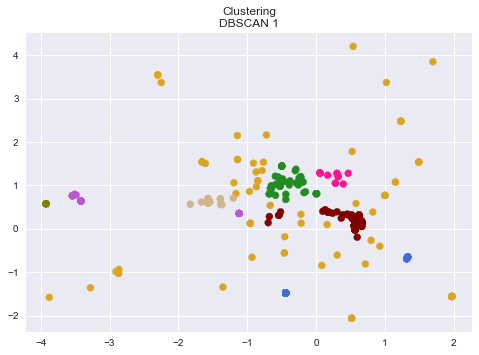

In [56]:
# plot dbscan 1

colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.scatter(X_norm[:,0], X_norm[:,1], c=vectorizer(labels_dbscan1))
plt.title('Clustering\nDBSCAN 1')
plt.show()

As a first attempt, it is by no means adequate to the level of capillarity necessary to find groups of visitors to the events of the Internet Festival. Therefore it is possible to see that the clusters on the map are too confused and mixed to be able to identify clear and precise divisions.
It is therefore necessary to try other parameters.

In [9]:
# prova 2: density based clustering
print('#DBSCAN 2')

parameters_ds2 = 'eps=0.2, min_samples=2'
dbscan2 = DBSCAN(eps=0.2, min_samples=2)
dbscan2.fit(X_norm)
labels_dbscan2 = dbscan2.labels_

hist_ds2, bins_ds2 = np.histogram(labels_dbscan2, bins=range(-1, len(set(labels_dbscan2)) + 1))

n_clust_ds2 = len(bins_ds2)
big_clust_ds2 = max(hist_ds2)
s_ds2 = metrics.silhouette_score(X_norm, labels_dbscan2)
mean_ds2 = statistics.mean(hist_ds2)
median_ds2 = statistics.median(hist_ds2)
out_ds2 = dict(zip(bins_ds2, hist_ds2))[-1]*100/sum(hist_ds2)

print ('parameters:', parameters_ds2)
print ('n. clusters:', n_clust_ds2)
print ('biggest cluster dimension:', big_clust_ds2)
print ('silhouette:', s_ds2)
print ('mean cluster dimension:', mean_ds2)
print ('median cluster dimension:', median_ds2)
print ('% outliers:', out_ds2)

#DBSCAN 2
parameters: eps=0.2, min_samples=2
n. clusters: 29
biggest cluster dimension: 308
silhouette: 0.7378839468500435
mean cluster dimension: 23
median cluster dimension: 4.0
% outliers: 3.177004538577912


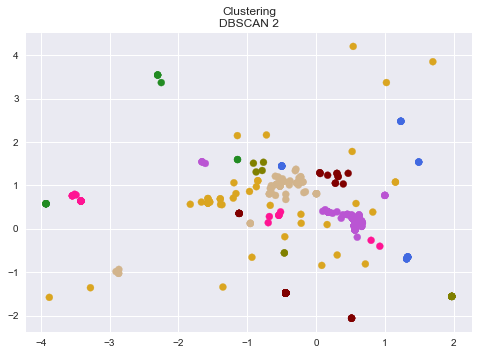

In [57]:
# plot dbscan 2

colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.scatter(X_norm[:,0], X_norm[:,1], c=vectorizer(labels_dbscan2))
plt.title('Clustering\nDBSCAN 2')
plt.show()

The resulting metrics from this latest application have greatly improved. In fact, we see that the number of clusters has increased from 15 to 29, with a much higher level of detail, just as the percentage of outliers has improved from 10.28 to 3.17 and the silhouette score from 0.68 to 0.73. On the other hand, for what concerns the biggest cluster size, there may still be improvements, as well as for the other metrics.

### Salvo il df con le labels del Dbscan1

In [11]:
'''
df_dbscan1 = df.copy()
df_dbscan1.insert(8, "Labels", labels_dbscan1, True)
#saving the dataframe
df_dbscan1.to_csv(csv_folder+'/df_dbscan1.csv')
'''

### Salvo il df con le labels del Dbscan2

In [12]:
'''
df_dbscan2 = df.copy()
df_dbscan2.insert(8, "Labels", labels_dbscan2, True)
#saving the dataframe
df_dbscan2.to_csv(csv_folder+'/df_dbscan2.csv')
'''

In [13]:
X_dbscan1 = X.copy() # creo un nuovo dataframe per aggiungere le lables ottenute dal clustering con dbscan1
X_dbscan1.insert(2, "Labels", labels_dbscan1, True)

X_dbscan2 = X.copy() # creo un nuovo dataframe per aggiungere le lables ottenute dal clustering con dbscan2
X_dbscan2.insert(2, "Labels", labels_dbscan2, True)

## Visualizzo i clusters sulla mappa con folium

In [15]:
lat = [43.7359, 43.6955]
lon = [10.4269, 10.3686]

lat_mean = np.mean(lat)
lon_mean = np.mean(lon)

lat, lng = (lat_mean, lon_mean)

In [16]:
import matplotlib.colors as colors

map_db1 = folium.Map(location=[lat, lng], zoom_start=13.3)

# set color scheme for the clusters
x = np.arange(len(bins_ds1))
ys = [i + x + (i*x)**2 for i in range(len(bins_ds1))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, cluster in zip(X_dbscan1['Lat'], X_dbscan1['Lon'],  
                                            X_dbscan1['Labels']):
    #label = folium.Popup(str(city)+ ','+str(state) + '- Cluster ' + str(cluster), parse_html=True)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        tooltip = 'Cluster ' + str(cluster),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_db1)

print('Map with DBSCAN 1 - '+year)
map_db1

Map with DBSCAN 1 - 2016


In [17]:
import matplotlib.colors as colors

map_db2 = folium.Map(location=[lat, lng], zoom_start=13.3)

# set color scheme for the clusters
x = np.arange(len(bins_ds2))
ys = [i + x + (i*x)**2 for i in range(len(bins_ds2))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, cluster in zip(X_dbscan2['Lat'], X_dbscan2['Lon'],  
                                            X_dbscan2['Labels']):
    #label = folium.Popup(str(city)+ ','+str(state) + '- Cluster ' + str(cluster), parse_html=True)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        tooltip = 'Cluster ' + str(cluster),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_db2)

print('Map with DBSCAN 2 - '+year)
map_db2

Map with DBSCAN 2 - 2016


# Clustering OPTICS

OPTICS (Ordering Points To Identify the Clustering Structure), closely related to DBSCAN, finds core sample of high density and expands clusters from them. Unlike DBSCAN, keeps cluster hierarchy for a variable neighborhood radius. Better suited for usage on large datasets than the current sklearn implementation of DBSCAN. (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html)
<li>min_samples (int > 1 or float between 0 and 1, default=5)
The number of samples in a neighborhood for a point to be considered as a core point. Also, up and down steep regions can’t have more than min_samples consecutive non-steep points. Expressed as an absolute number or a fraction of the number of samples (rounded to be at least 2).</li>

In [18]:
# optics 1 clustering
print('#OPTICS 1')

parameters_opt1 = 'min_samples=5, default metric=minkowski'
optics1 = OPTICS(min_samples=5).fit(X_norm) #default metric = minkowski
labels_opt1 = optics1.labels_

hist_opt1, bins_opt1 = np.histogram(labels_opt1, bins=range(-1, len(set(labels_opt1)) + 1))

n_clust_opt1 = len(bins_opt1)
big_clust_opt1 = max(hist_opt1)
s_opt1 = metrics.silhouette_score(X_norm, labels_opt1)
mean_opt1 = statistics.mean(hist_opt1)
median_opt1 = statistics.median(hist_opt1)
out_opt1 = dict(zip(bins_opt1, hist_opt1))[-1]*100/sum(hist_opt1)

print ('parameters:', parameters_opt1)
print ('n. clusters:', n_clust_opt1)
print ('biggest cluster dimension:', big_clust_opt1)
print ('silhouette:', s_opt1)
print ('mean cluster dimension:', mean_opt1)
print ('median cluster dimension:', median_opt1)
print ('% outliers:', out_opt1)

#OPTICS 1
parameters: min_samples=5, default metric=minkowski
n. clusters: 28
biggest cluster dimension: 163
silhouette: 0.7110687027019293
mean cluster dimension: 24
median cluster dimension: 9
% outliers: 12.708018154311649


/Users/ariannalisi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


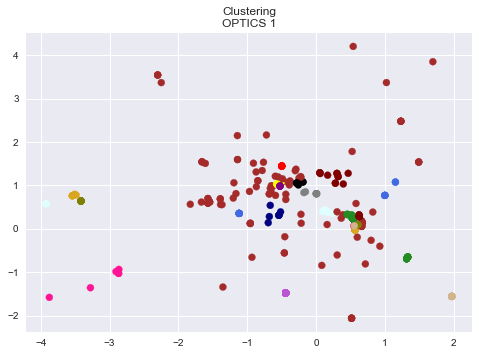

In [19]:
# PLOT OPTICS 1
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy', 'yellow', 'purple', 'black', 'grey', 'red', 'brown']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.scatter(X_norm[:,0], X_norm[:,1], c=vectorizer(labels_opt1), marker="o", picker=True)
plt.title('Clustering\nOPTICS 1')
plt.show()

Clusters definition is very approximative, so we notice that we need a smaller number of samples in a neighborhood for a point to be considered as a core point. Therefore, we try the same algorithm changing parameters: min_spamples equal to 3 and min_cluster_size, which is the minimum number of samples in an OPTICS cluster, equal to 2. 

In [20]:
# optics 2 clustering
print('#OPTICS 2')
       
parameters_opt2 = 'min_samples=3, min_cluster_size=2, default metric=minkowski'
optics2 = OPTICS(min_samples=3, min_cluster_size=2).fit(X_norm) #default metric = minkowski
labels_opt2 = optics2.labels_

hist_opt2, bins_opt2 = np.histogram(labels_opt2, bins=range(-1, len(set(labels_opt2)) + 1))

n_clust_opt2 = len(bins_opt2)
big_clust_opt2 = max(hist_opt2)
s_opt2 = metrics.silhouette_score(X_norm, labels_opt2)
mean_opt2 = statistics.mean(hist_opt2)
median_opt2 = statistics.median(hist_opt2)
out_opt2 = dict(zip(bins_opt2, hist_opt2))[-1]*100/sum(hist_opt2)

print ('parameters:', parameters_opt2)
print ('n. clusters:', n_clust_opt2)
print ('biggest cluster dimension:', big_clust_opt2)
print ('silhouette:', s_opt2)
print ('mean cluster dimension:', mean_opt2)
print ('median cluster dimension:', median_opt2)
print ('% outliers:', out_opt2)

#OPTICS 2
parameters: min_samples=3, min_cluster_size=2, default metric=minkowski
n. clusters: 49
biggest cluster dimension: 163
silhouette: 0.8040413741648764
mean cluster dimension: 13
median cluster dimension: 4.5
% outliers: 7.866868381240544


/Users/ariannalisi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


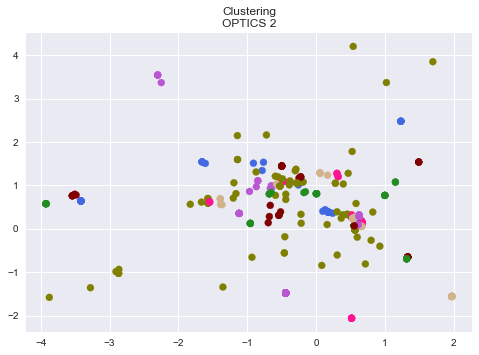

In [21]:
# PLOT OPTICS 2
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.scatter(X_norm[:,0], X_norm[:,1], c=vectorizer(labels_opt2), marker="o", picker=True)
plt.title('Clustering\nOPTICS 2')
plt.show()

Here we can discern that the number of clusters has increased from 28 to 49, meaning that the precision has clearly increased and that the parameters are more suitable for an analysis of this type, that is, in a relatively small space and which contains a vast constellation of small clusters. 

In [22]:
X_optics1 = X.copy() # creo un nuovo dataframe per aggiungere le lables ottenute dal clustering con optics1
labels_optics1 = labels_opt1 #per praticità
X_optics1.insert(2, "Labels", labels_optics1, True)

X_optics2 = X.copy() # creo un nuovo dataframe per aggiungere le lables ottenute dal clustering con optics1
labels_optics2 = labels_opt2 #per praticità
X_optics2.insert(2, "Labels", labels_optics2, True)

In [55]:
df_optics2 = df.copy()
df_optics2.insert(8, "Labels", labels_optics2, True)
#saving the dataframe
df_optics2.to_csv(csv_folder+'/df_optics2.csv')

## Visualizzo i clusters sulla mappa con folium

In [25]:
import matplotlib.colors as colors

map_optics1 = folium.Map(location=[lat, lng], zoom_start=13.3)

# set color scheme for the clusters
x = np.arange(len(bins_opt1))
ys = [i + x + (i*x)**2 for i in range(len(bins_opt1))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors1 = []
for lat, lng, cluster in zip(X_optics1['Lat'], X_optics1['Lon'],  
                                            X_optics1['Labels']):
    #label = folium.Popup(str(city)+ ','+str(state) + '- Cluster ' + str(cluster), parse_html=True)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        tooltip = 'Cluster ' + str(cluster),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_optics1)

print('Map with Optics 1 - '+year)
map_optics1

Map with Optics 1 - 2016


In [26]:
import matplotlib.colors as colors

map_optics2 = folium.Map(location=[lat, lng], zoom_start=13.3)

# set color scheme for the clusters
x = np.arange(len(bins_opt2))
ys = [i + x + (i*x)**2 for i in range(len(bins_opt2))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors1 = []
for lat, lng, cluster in zip(X_optics2['Lat'], X_optics2['Lon'],  
                                            X_optics2['Labels']):
    #label = folium.Popup(str(city)+ ','+str(state) + '- Cluster ' + str(cluster), parse_html=True)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        tooltip = 'Cluster ' + str(cluster),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_optics2)

print('Map with Optics 2 - '+year)
map_optics2

Map with Optics 2 - 2016


# Bisecting-Kmeans

Another algorithm that can be used for this study is Bisecting-Kmeans, which is a straightforward extension of the basic K-Means algorithm. It follows a very simple procedure, that is to split the set of all points into two clusterrs, select one of these clustes to split and continue until K clusters have been produced. 
An algorithm based on our needs has been written following this basic idea, and the parameters used have been initialized in the following way:
- k=2,
- min_cluster_size=1,
- min_split_size=3,
- max_distance_thr=100/1000 (kilometers),
- max_nbr_clusters_iter=100,
- max_iter=300,
- metric="euclidean",
- random_state=None 

In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import metrics

In [28]:
%load_ext autoreload
%autoreload 2

from bisecting_kmeans import BisectingKMeans

In [29]:
X_bk = df[['Lat', 'Lon']].copy()
X_geo = np.array(X_bk.values.tolist())

max_distance_thr = 100 # meters
max_distance_thr = max_distance_thr / 1000 # kilometers

bkmeans = BisectingKMeans(min_cluster_size=1, max_distance_thr=max_distance_thr, metric='haversine', random_state=0)
bkmeans.fit(X_geo)

In [30]:
values_bk, counts_bk = np.unique(bkmeans.labels_, return_counts=True)

In [31]:
values_bk

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51])

In [32]:
counts_bk

array([ 15,   3,  11,   3,   4,  66,   3,   6,   4,   3,  53,   7,   2,
         3,   6,   3,   4, 138,   2,   2,   5,   2,  11,   4,   4,   2,
         3,  16,   9,   5,   2,   3,  13,   4,   3,   4,  14,   2,   2,
        12,   3,   4,   7,   2,   4,   2,   3, 163,   2,   2,   4,   4,
         3])

In [33]:
#possibili analisi/stampe

#bkmeans.labels_
#bkmeans.cluster_centers_
#bkmeans.sse_
#metrics.silhouette_score(X_geo, bkmeans.labels_, metric='euclidean')
#bkmeans.sse_list_

In [34]:
import statistics
print('#BKMEANS')

parameters_bk = 'min_cluster_size=1, max_distance_thr=100/1000 (km), metric=haversine, random_state=0'

n_clust_bk = len(values_bk)
big_clust_bk = max(counts_bk)
s_bk = metrics.silhouette_score(X_geo, bkmeans.labels_, metric='euclidean')
mean_bk = statistics.mean(counts_bk)
median_bk = statistics.median(counts_bk)
out_bk = 16*100/sum(counts_bk)

print ('parameters:', parameters_bk)
print ('n. clusters:', n_clust_bk)
print ('biggest cluster dimension:', big_clust_bk)
print ('silhouette:', s_bk)
print ('mean cluster dimension:', mean_bk)
print ('median cluster dimension:', median_bk)
print ('% outliers:', out_bk)

#BKMEANS
parameters: min_cluster_size=1, max_distance_thr=100/1000 (km), metric=haversine, random_state=0
n. clusters: 53
biggest cluster dimension: 163
silhouette: 0.803241569685739
mean cluster dimension: 12
median cluster dimension: 4
% outliers: 2.4205748865355523


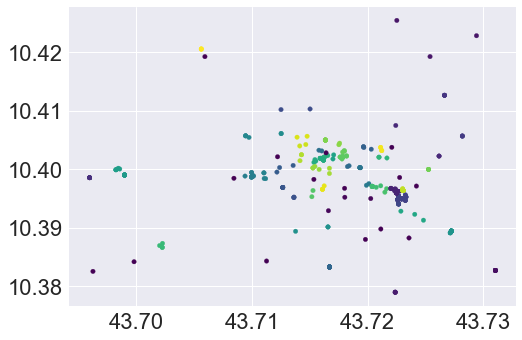

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('seaborn')

plt.scatter(X_geo[:,0], X_geo[:,1], c=bkmeans.labels_, s=20, cmap='viridis')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

The results from the application of this algorithm are much more satisfactory than the others: first of all we notice that the number of clusters has increased again (from 49 to 53), therefore we have a more detailed subdivision, with a consequent decrease in the percentage of outliers that have been excluded, while the silhouette is remained almost the same at a good score.

## Visualizzo i clusters sulla mappa con folium

In [36]:
import matplotlib.colors as colors

map_bk = folium.Map(location=[lat, lng], zoom_start=13.3)

# set color scheme for the clusters
x = np.arange(len(values_bk))
ys = [i + x + (i*x)**2 for i in range(len(values_bk))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors1 = []
for lat, lng, cluster in zip(X_geo[:,0], X_geo[:,1],  bkmeans.labels_):
    #label = folium.Popup(str(city)+ ','+str(state) + '- Cluster ' + str(cluster), parse_html=True)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        tooltip = 'Cluster ' + str(cluster),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_bk)

print('Map with Bisecting-Kmeans - '+year)
map_bk

Map with Bisecting-Kmeans - 2016


### Salvo il df con le labels di Bisecting-Kmeans

In [37]:
df_bk = df.copy()
df_bk.insert(8, "Labels", bkmeans.labels_, True)
#saving the dataframe
df_bk.to_csv(csv_folder+'/df_bkmeans.csv')

# GEOHASH

In [38]:
X_geohash = X.copy()
X_geohash['geohash'] = X_geohash.apply(lambda x: gh.encode(x.Lat, x.Lon, precision=6), axis=1)

Conto i codici geohash per poi creare una mappa e creare la scala:

In [39]:
count_geohash = []
codes_geohash = X_geohash['geohash'].tolist()
codes_geohash.sort()

In [40]:
values = []

for code_geohash in codes_geohash:
    values.append(codes_geohash.count(code_geohash))
    
values_array = np.array(values)

values = set(values_array)
values

{1, 2, 4, 5, 6, 7, 8, 12, 14, 27, 32, 63, 142, 322}

In [41]:
#per ora non uso l'array normalizzato!
'''
norm = np.linalg.norm(values_array)
normal_array = values_array/norm
print(normal_array)
'''

'\nnorm = np.linalg.norm(values_array)\nnormal_array = values_array/norm\nprint(normal_array)\n'

### Understanding tests:

In [42]:
decoded_location = gh.decode(X_geohash['geohash'][0])
decoded_location2 = gh.decode(X_geohash['geohash'][1])

In [43]:
decoded_location

(43.72833251953125, 10.4095458984375)

In [44]:
decoded_location2

(43.72833251953125, 10.4095458984375)

In [45]:
gh.neighbors(X_geohash['geohash'][0])

['spz2u8',
 'spz2v0',
 'spz2sz',
 'spz2sx',
 'spz2tp',
 'spz2uc',
 'spz2u9',
 'spz2v1']

In [46]:
gh.neighbors(X_geohash['geohash'][200])

['spz2sr',
 'spz2sz',
 'spz2sw',
 'spz2sq',
 'spz2sy',
 'spz2u8',
 'spz2u2',
 'spz2ub']

### Creo un dataframe per poi costruire la griglia con i codici geohash sulla mappa folium:

In [47]:
import json
# Create Geo Pandas DataFrame
df_geo = gpd.GeoDataFrame({'location':df_coords.tolist(), 'value': values_array})
df_geo['geohash'] = X_geohash['geohash']
df_geo['geometry'] = df_geo['geohash'].apply(geohash_to_polygon)
df_geo.crs = {'init': 'epsg:4326'}


print('features.properties.geohash')
display(json.loads(df_geo.to_json())['features'][0])
display(df_geo.head())

features.properties.geohash


/Users/ariannalisi/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


{'id': '0',
 'type': 'Feature',
 'properties': {'geohash': 'spz2ub',
  'location': '[43.72666207, 10.41268069]',
  'value': 1},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[10.404052734375, 43.7255859375],
    [10.4150390625, 43.7255859375],
    [10.4150390625, 43.7310791015625],
    [10.404052734375, 43.7310791015625],
    [10.404052734375, 43.7255859375]]]}}

location  value geohash  \
0  [43.72666207, 10.41268069]      1  spz2ub   
1  [43.72666207, 10.41268069]      5  spz2ub   
2  [43.72666207, 10.41268069]      5  spz2ub   
3          [43.7167, 10.3833]      5  spz2sq   
4        [43.70561, 10.42059]      5  spz2th   

                                            geometry  
0  POLYGON ((10.40405 43.72559, 10.41504 43.72559...  
1  POLYGON ((10.40405 43.72559, 10.41504 43.72559...  
2  POLYGON ((10.40405 43.72559, 10.41504 43.72559...  
3  POLYGON ((10.38208 43.71460, 10.39307 43.71460...  
4  POLYGON ((10.41504 43.70361, 10.42603 43.70361...

In [48]:
m_geohash = folium.Map((lat, lng), zoom_start=13.2)
folium.Choropleth(geo_data=df_geo, 
                  name='choropleth',
                  data=df_geo,
                  columns=['geohash', 'value'],
                  key_on='feature.properties.geohash',
                  fill_color='YlGn',
                  fill_opacity=0.7,
                  line_opacity=0.2,
                  legend_name='asdf').add_to(m_geohash)
m_geohash

In [49]:
df_geohash = df.copy()
df_geohash.insert(8, "geohash", X_geohash['geohash'] , True)
#saving the dataframe
df_geohash.to_csv(csv_folder+'/df_geohash.csv')

In [50]:
# raggruppo il df in base ai codici geohash per cambiare nome in numeri e renderli più comprensibili
Geohash_codes = df_geohash.groupby(['geohash'])

lista = []
i = 0

for key, items in Geohash_codes:
    df_geohash['geohash'] = df_geohash['geohash'].replace(key, i)
    i = i+1

#saving the dataframe
df_geohash.to_csv(csv_folder+'/df_geohash_to_numbers.csv')

# TABELLA CONFRONTO CLUSTERING

In [52]:
table = pd.DataFrame()

#table=['Algorithm', 'Parameters', 'N. Clusters', 'Perc. Outliers', 
 #                             'Mean (cluster dimension)', 'Median (cluster dimension)', 
  #                            'Biggest cluster dimension', 'Silhouette']

table['Algorithm'] = ['Dbscan1', 'Dbscan2',
                      'Optics1', 'Optics2', 'Bisecting-Kmeans']

table['Parameters'] = [parameters_ds1, parameters_ds2, 
                       parameters_opt1, parameters_opt2, parameters_bk]

table['N. Clusters'] = [n_clust_ds1, n_clust_ds2,
                       n_clust_opt1, n_clust_opt2, n_clust_bk]

table['Perc. Outliers'] = [out_ds1, out_ds2,
                           out_opt1, out_opt2, out_bk]

table['Mean (cluster dimension)'] = [mean_ds1, mean_ds2, 
                                     mean_opt1, mean_opt2, mean_bk]

table['Median (cluster dimension)'] = [median_ds1, median_ds2, 
                                       median_opt1, median_opt2, median_bk]

table['Biggest cluster dimension'] = [big_clust_ds1, big_clust_ds2, 
                                       big_clust_opt1, big_clust_opt2, big_clust_bk]

table['Silhouette'] = [s_ds1, s_ds2, 
                        s_opt1, s_opt2, s_bk]

table

Algorithm                                         Parameters  \
0           Dbscan1                             eps=0.2, min_samples=5   
1           Dbscan2                             eps=0.2, min_samples=2   
2           Optics1            min_samples=5, default metric=minkowski   
3           Optics2  min_samples=3, min_cluster_size=2, default met...   
4  Bisecting-Kmeans  min_cluster_size=1, max_distance_thr=100/1000 ...   

   N. Clusters  Perc. Outliers  Mean (cluster dimension)  \
0           15       10.287443                        47   
1           29        3.177005                        23   
2           28       12.708018                        24   
3           49        7.866868                        13   
4           53        2.420575                        12   

   Median (cluster dimension)  Biggest cluster dimension  Silhouette  
0                        13.0                        308    0.688300  
1                         4.0                        308    0.737884  
2                         9.0                        163    0.711069  
3                         4.5                        163    0.804041  
4                         4.0                        163    0.803242

### Adding style for highlighting the most significant algorithms

In [53]:
highlight = lambda x: ['background: #f2dbaa' if x.name in [3,4] else '' for i in x]
table = table.style
table = table.hide_index()
table = table.apply(highlight, axis=1)
table

In [54]:
table.to_excel(csv_folder+'/table_clustering.xlsx') 